## Data

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from hopfield import (
    NonidentityRecon, DiscreteTimeHopfieldLayer, softsign)
from mnist import load_mnist
from lena import load_lena, binary_repr

%matplotlib inline

tf.random.set_seed(42)
tf.keras.backend.clear_session()
print(tf.__version__)

2.3.1


In [2]:
IMAGE_SIZE = (32, 32)  # XXX: test!
# IMAGE_SIZE = (8, 8)
BINARIZE = True

In [6]:
(x_train, _), _ = load_mnist(image_size=IMAGE_SIZE, binarize=BINARIZE)

In [8]:
# x_train = load_lena()
# num_bits = 2
# x_train = tf.cast(
#     x_train / 255 * 2 ** num_bits,
#     'int32')
# x_train = tf.reshape(binary_repr(x_train[..., 0]), [-1, 2 ** 11])
# x_train = tf.cast(x_train, 'float32')

In [9]:
x_train

<tf.Tensor: shape=(60000, 1024), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>

## Model

In [10]:
class RBMRecon(NonidentityRecon):
    """Restricted Boltzmann machine (RBM) based non-identity re-constructor.

    RBM -- LDPC -- AE

    Notes
    -----
    Non-identity: The latent dimension `latent_dim` shall be smaller the
        ambient dimension, for ensuring the non-identity of the re-constructor.

    References
    ----------
    * Introduction to low-density parity-check (LDPC) code:
        1. https://medium.com/5g-nr/ldpc-low-density-parity-check-code-8a4444153934
    * Introduction to Boltzmann machine:
        2. https://medium.com/edureka/restricted-boltzmann-machine-tutorial-991ae688c154
    * Relation between Boltzmann machine and auto-encoder:
        3. https://www.cs.cmu.edu/~rsalakhu/talk_Simons_part2_pdf.pdf

    Parameters
    ----------
    latent_dim : int
    softsign : callable, optional
        Soft version of `sign` function. Softness means that the output of the
        function is hard version, while the gradient is smooth (i.e. custom
        gradient).
    """

    def __init__(self,
                 latent_dim,
                 softsign=softsign,
                 **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.softsign = softsign

    def get_config(self):
        config = super().get_config()
        config['latent_dim'] = self.latent_dim
        config['softsign'] = self.softsign
        return config

    def build(self, input_shape):
        depth = input_shape[-1]
        assert depth > self.latent_dim

        self.kernel = self.add_weight(
            name='kernel',
            shape=[depth, self.latent_dim],
            initializer='glorot_uniform',
            trainable=True)
        self.latent_bias = self.add_weight(
            name='latent_bias',
            shape=[self.latent_dim],
            initializer='zeros',
            trainable=True)
        self.ambient_bias = self.add_weight(
            name='ambient_bias',
            shape=[depth],
            initializer='zeros',
            trainable=True)
        super().build(input_shape)

    def call(self, x):
        f = self.softsign
        W, b, v = self.kernel, self.latent_bias, self.ambient_bias
        z = f(x @ W + b)
        y = f(z @ tf.transpose(W) + v)
        return y

In [64]:
from hopfield import step


def outer(x, y):
    return x[..., :, tf.newaxis] * y[..., tf.newaxis, :]


class RBMWithHebbianLearning(NonidentityRecon):
    """Restricted Boltzmann machine (RBM) based non-identity re-constructor.

    Parameters
    ----------
    latent_dim : int
    """

    def __init__(self,
                 latent_dim,
                 **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
        self.activation = lambda x: step(x, threshold=0, minval=-1, maxval=1)

    def get_config(self):
        config = super().get_config()
        config['latent_dim'] = self.latent_dim
        return config

    def build(self, input_shape):
        depth = input_shape[-1]
        assert depth > self.latent_dim

        self.kernel = self.add_weight(
            name='kernel',
            shape=[depth, self.latent_dim],
            initializer='zeros',
            trainable=False)
        self.latent_bias = self.add_weight(
            name='latent_bias',
            shape=[self.latent_dim],
            initializer='zeros',
            trainable=False)
        self.ambient_bias = self.add_weight(
            name='ambient_bias',
            shape=[depth],
            initializer='zeros',
            trainable=False)
        super().build(input_shape)

    def call(self, x, training=None):
        f = self.activation
        W, b, v = self.kernel, self.latent_bias, self.ambient_bias
        z = f(x @ W + b)
        new_x = f(z @ tf.transpose(W) + v)
        
        if training:
            new_z = f(new_x @ W + b)
            dW = tf.reduce_sum(outer(x, z) - outer(new_x, new_z),
                               axis=0)
            db = tf.reduce_sum(z - new_z, axis=0)
            dv = tf.reduce_sum(x - new_x, axis=0)
            W.assign_add(dW)
            b.assign_add(db)
            v.assign_add(dv)

        return new_x

In [65]:
def create_model(num_repeat, latent_dim):
    model = tf.keras.Sequential([
        DiscreteTimeHopfieldLayer(
            # RBMRecon(latent_dim),
            RBMWithHebbianLearning(latent_dim),
            max_steps=20,
            reg_factor=1),
    ])
    model.compile(optimizer='adam')
    return model

In [66]:
X = x_train[:100].numpy()

ds0 = tf.data.Dataset.from_tensor_slices(X)
ds = ds0.shuffle(10000).repeat(10000).batch(128)
model = create_model(num_repeat=1, latent_dim=256)
model.fit(ds)

 433/7813 [>.............................] - ETA: 15:48 - loss: 0.3226

KeyboardInterrupt: 

In [67]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discrete_time_hopfield_layer (None, 1024)              263425    
Total params: 263,425
Trainable params: 0
Non-trainable params: 263,425
_________________________________________________________________


In [78]:
# noised_X = X + np.random.normal(size=X.shape) * 0.3
noised_X = np.where(np.random.random(size=X.shape) < 0.2, -X, X)
recon_X = model.predict(noised_X)

for layer in model.layers:
    try:
        print('Relax steps:', layer.final_step.numpy())
    except AttributeError:
        pass

orig_err = noised_X - X
err = recon_X - X
print(f'{np.quantile(np.abs(orig_err), 0.98)} => '
      f'{np.quantile(np.abs(err), 0.98)}')

Relax steps: 1
0.0 => 2.0


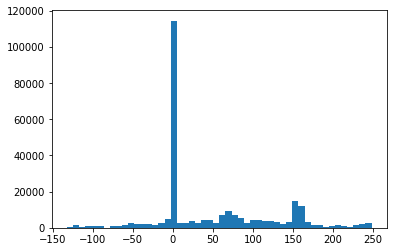

In [71]:
hopfield_layer = None
for layer in model.layers:
    if isinstance(layer, DiscreteTimeHopfieldLayer):
        hopfield_layer = layer

original_W = hopfield_layer.non_identity_recon.kernel.numpy()

# plot W's histogram
plt.hist(original_W.reshape([-1]), bins=50)
plt.show()

In [ ]:
# clip the small value elements of the W
clipped_W = np.where(np.abs(original_W) < 0.05, 0., original_W)
hopfield_layer.non_identity_recon.kernel.assign(
    tf.constant(clipped_W, dtype='float32'))

# plot W's histogram, after clipping
plt.hist(clipped_W.reshape([-1]), bins=50)
plt.show()

In [ ]:
# use the clipped model to test the de-noising effect

recon_X = model.predict(noised_X)

for layer in model.layers:
    try:
        print('Relax steps:', layer.final_step.numpy())
    except AttributeError:
        pass

orig_err = noised_X - X
err = recon_X - X
print(f'{np.quantile(np.abs(orig_err), 0.98)} => '
      f'{np.quantile(np.abs(err), 0.98)}')

In [ ]:
# clip ratio

clip_ratio = 1 - np.sum(clipped_W > 0) / np.sum(original_W > 0)
print(clip_ratio, np.sum(clipped_W > 0) // (IMAGE_SIZE[0] * IMAGE_SIZE[1]))

## Conclusions

1. RBM based (soft) binary re-constructor also provides the de-noising property for the discrete-time Hopfield network. Also, it solves the problem of the traditional dense re-constructor, the case where the input dimension is too small so that the perceptron cannot get enough capacity for learning sufficient many patterns. (Recall that simply duplicating the pattern will break the non-identity down for the traditional dense re-constructor. But it's fine in case of the RBM based re-constructor.)
1. However, comparing with the traditional dense re-constructor, the de-noising effect, even though still persists, reduces.
1. Using soft activation in training phase while hard one in other phase cannot gain the previous properties. Only with a soften hard-activation can it gain. The reason maybe that binarization of output will reduce the difficulty of learning, since this output, as the input of the next layer, is regularized for the next layer.